In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive, files

In [ ]:
#files.upload() #for uploading of files from local repository
drive.mount('/content/data')

Drive already mounted at /content/data; to attempt to forcibly remount, call drive.mount("/content/data", force_remount=True).


In [ ]:
file_loc = './data/MyDrive/AI Python Portfolio/(RNN) Singapore Temperature Forecast/data/SingaporeTemperatureData.csv'


#Explore Data
Understand data and variable types. Check data range and null values.

In [ ]:
#Read csv and view data
dfraw = pd.read_csv(file_loc)
dfraw

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1825-01-01,25.332,3.194,Singapore,Singapore,0.80N,103.66E
1,1825-02-01,25.549,1.471,Singapore,Singapore,0.80N,103.66E
2,1825-03-01,26.285,2.193,Singapore,Singapore,0.80N,103.66E
3,1825-04-01,26.999,2.571,Singapore,Singapore,0.80N,103.66E
4,1825-05-01,27.450,1.591,Singapore,Singapore,0.80N,103.66E
...,...,...,...,...,...,...,...
2260,01/05/2013,28.083,0.189,Singapore,Singapore,0.80N,103.66E
2261,01/06/2013,28.662,0.431,Singapore,Singapore,0.80N,103.66E
2262,01/07/2013,27.487,0.418,Singapore,Singapore,0.80N,103.66E
2263,01/08/2013,27.372,0.417,Singapore,Singapore,0.80N,103.66E


In [ ]:
#Check data types and overall information
dfraw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2265 entries, 0 to 2264
Data columns (total 7 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   dt                             2265 non-null   object 
 1   AverageTemperature             2052 non-null   float64
 2   AverageTemperatureUncertainty  2052 non-null   float64
 3   City                           2265 non-null   object 
 4   Country                        2265 non-null   object 
 5   Latitude                       2265 non-null   object 
 6   Longitude                      2265 non-null   object 
dtypes: float64(2), object(5)
memory usage: 124.0+ KB


In [ ]:
#View metrics for information and general feel
dfraw.describe()

,AverageTemperature,AverageTemperatureUncertainty
count,2052.000000,2052.000000
mean,26.523103,0.621055
std,0.742396,0.482448
min,24.032000,0.065000
25%,26.053000,0.282000
50%,26.546500,0.435000
75%,27.002250,0.808750
max,28.880000,3.517000


In [ ]:
#Check null values and their counts and location
dfraw.isna().sum()

dt                                 0
AverageTemperature               213
AverageTemperatureUncertainty    213
City                               0
Country                            0
Latitude                           0
Longitude                          0
dtype: int64

#Data Preprocessing
Remove non-relevant columns and manage null values. 
NOTE: Section was edited after multiple iterations to improve model.

In [ ]:
#Drop columns which do not affect temperature
df = dfraw.drop(['City','Country','Latitude','Longitude'], axis=1)
df

,dt,AverageTemperature,AverageTemperatureUncertainty
0,1825-01-01,25.332,3.194
1,1825-02-01,25.549,1.471
2,1825-03-01,26.285,2.193
3,1825-04-01,26.999,2.571
4,1825-05-01,27.450,1.591
...,...,...,...
2260,01/05/2013,28.083,0.189
2261,01/06/2013,28.662,0.431
2262,01/07/2013,27.487,0.418
2263,01/08/2013,27.372,0.417


In [ ]:
#Existing dates were formatted differently. Converted to uniform date format and date object.
date1 = pd.to_datetime(df['dt'], format='%Y-%m-%d', errors='coerce')
date2 = pd.to_datetime(df['dt'], dayfirst='%d/%m/%y', errors='coerce')
df['dt'] = date1.combine_first(date2)

In [ ]:
#Check if dtype changed to 'datetime'
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2265 entries, 0 to 2264
Data columns (total 3 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   dt                             2265 non-null   datetime64[ns]
 1   AverageTemperature             2052 non-null   float64       
 2   AverageTemperatureUncertainty  2052 non-null   float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 53.2 KB


In [ ]:
#Create new columns for data manipulation
df['Year'] = df['dt'].dt.year
df['Month'] = df['dt'].dt.month
df['Century'] = df['Year'].apply(lambda year: year//100)

In [ ]:
#Fill NaN with Yearly mean if available.
df['AverageTemperature'] = df.groupby('Year')['AverageTemperature'].transform(lambda x: x.fillna(x.mean()))

#Fill NaN with Century mean if yearly mean not available.
df['AverageTemperature'] = df.groupby('Century')['AverageTemperature'].transform(lambda x: x.fillna(x.mean()))

In [ ]:
#Check if there are still NaN / null values
df.isna().sum()

dt                                 0
AverageTemperature                 0
AverageTemperatureUncertainty    213
Year                               0
Month                              0
Century                            0
dtype: int64

In [ ]:
#Decision made after some iterations to drop early values (previously NaN)
#This line of code rendered some lines above redundant.
df = df[df['Year']>1899]

In [ ]:
#Drop columns which are no longer useful
df = df.drop(['Year','Century','Month','AverageTemperatureUncertainty'], axis=1)

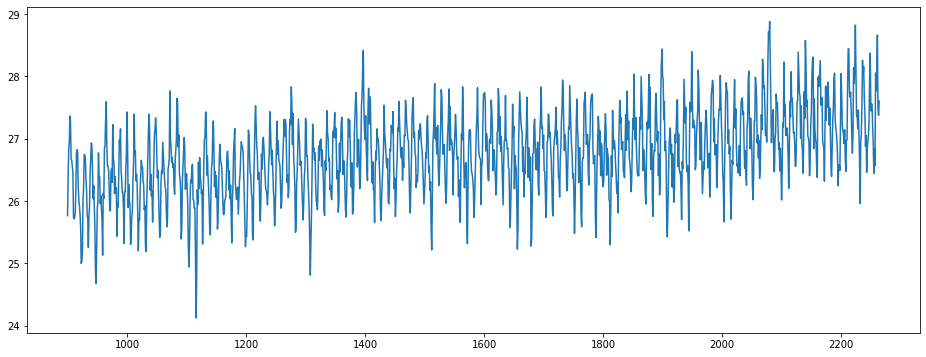

In [ ]:
#Get visuals of processed data.
plt.figure(figsize=(16,6))
plt.plot(df.index,'AverageTemperature', data=df)

#Model Training and Fitting
Scale and fit model to data. Setup generators for training and validation. 

In [ ]:
#Set date column to be the index.
df = df.set_index('dt')

In [ ]:
#Check length of dataset
len(df)

1365

In [ ]:
#Split into training and validation sets. Last 10 years (arbituary selection) of data will be used for validation.
#Since each point represents a month, 10 years of data would consist of 10*12 points.
test_size = 10*12
test_ind = len(df) - test_size

In [ ]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

In [ ]:
#Check if split is done correctly
test

,AverageTemperature
dt,
2003-10-01,27.015000
2003-11-01,26.937000
2003-12-01,26.406000
2004-01-01,26.648000
2004-02-01,27.225000
...,...
2013-05-01,28.083000
2013-06-01,28.662000
2013-07-01,27.487000


In [ ]:
from sklearn.preprocessing import MinMaxScaler 

In [ ]:
#Scale data for modelling
scaler = MinMaxScaler()

In [ ]:
scaler.fit(train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [ ]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [ ]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [ ]:
#Training data generator. Set length to 2 years of value.
length = 24
batch_size = 1
generator = TimeseriesGenerator(scaled_train, scaled_train,
                                length=length,
                                batch_size = batch_size)

In [ ]:
#Validation data generator. Set length to 2 years of value.
length = 24
batch_size = 1
val_generator = TimeseriesGenerator(scaled_test, scaled_test,
                                length=length,
                                batch_size = batch_size)

In [ ]:
#Check if generator is generating the correct output.
generator[0]

(array([[[0.34496531],
         [0.47550978],
         [0.57073786],
         [0.59365146],
         [0.68110153],
         [0.66218205],
         [0.53710322],
         [0.53226824],
         [0.5101955 ],
         [0.49253731],
         [0.34160185],
         [0.33403406],
         [0.34139163],
         [0.35295354],
         [0.4401934 ],
         [0.5560227 ],
         [0.56779483],
         [0.56064747],
         [0.44103427],
         [0.39793988],
         [0.37691823],
         [0.35190246],
         [0.30754677],
         [0.18393946]]]), array([[0.19108682]]))

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
#Only 1 feature used (i.e. Average Temp) for training
n_features = 1

In [ ]:
#Create model. Number of nodes and activation function were iterated and optimised with different values to improve results.
model = Sequential()

model.add(LSTM(150, activation='relu', input_shape=(length,n_features)))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

In [ ]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 150)               91200     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 151       
Total params: 91,351
Trainable params: 91,351
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#Set up early stopping parameter. Patience is also optimised with iterations.
early_stop = EarlyStopping(monitor="val_loss", patience=5)

In [ ]:
#Fit model to training data. High epoch set with early stopping.
model.fit_generator(generator, epochs=20, callbacks=[early_stop], validation_data=val_generator)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
1221/1221 [==============================] - 17s 13ms/step - loss: 0.0168 - val_loss: 0.0148
Epoch 2/20
1221/1221 [==============================] - 16s 13ms/step - loss: 0.0079 - val_loss: 0.0064
Epoch 3/20
1221/1221 [==============================] - 16s 13ms/step - loss: 0.0061 - val_loss: 0.0123
Epoch 4/20
1221/1221 [==============================] - 16s 13ms/step - loss: 0.0060 - val_loss: 0.0116
Epoch 5/20
1221/1221 [==============================] - 16s 13ms/step - loss: 0.0057 - val_loss: 0.0061
Epoch 6/20
1221/1221 [==============================] - 16s 13ms/step - loss: 0.0056 - val_loss: 0.0063
Epoch 7/20
1221/1221 [==============================] - 16s 13ms/step - loss: 0.0055 - val_loss: 0.0077
Epoch 8/20
1221/1221 [==============================] - 16s 13ms/step - loss: 0.0050 - val_loss: 0.0076
Epoch 9/20
1221/1221 [==============================] - 16s 13ms/step - loss: 0.0050 - val_loss: 0.0059
Epoch 10/20
1221/1221 [==============================] - 16s 13m

#Model Evaluation
Evaluate performance of model. Check predictions with validation test values. Iterate fitting to optimise performance.

In [ ]:
#View model performance.
losses = pd.DataFrame(model.history.history)

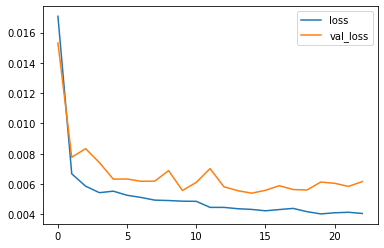

In [ ]:
losses.plot()

In [ ]:
#Use model to predict the validation data.
test_pred = []

first_batch = scaled_test[-length:]
current_batch = first_batch.reshape((1,length,n_features))

for i in range(len(scaled_test)):
  current_pred = model.predict(current_batch)[0]
  test_pred.append(current_pred)
  current_batch = np.append(current_batch[:,1:,:], [[current_pred]], axis=1)

In [ ]:
#Since we are comparing with the validation data, we check if they are of the same length as we set it to be.
len(test)==len(test_pred)

True

In [ ]:
#Add prediction by the model to the test dataframe. Not forgetting to inverse the scaling.
test['Predicted_Avg'] = scaler.inverse_transform(test_pred)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
#Check if the data is inserted correctly
test

,AverageTemperature,Predicted_Avg
dt,,
2003-10-01,27.015000,27.250856
2003-11-01,26.937000,27.044265
2003-12-01,26.406000,26.789616
2004-01-01,26.648000,26.603241
2004-02-01,27.225000,27.129424
...,...,...
2013-05-01,28.083000,28.631658
2013-06-01,28.662000,28.615504
2013-07-01,27.487000,28.262732


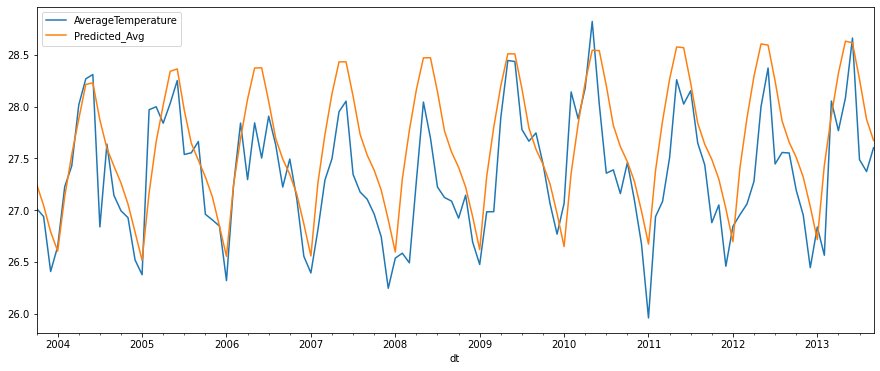

In [ ]:
#Compare predictions using a plot
test.plot(figsize=(15,6))

In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
#Check root mean square error for comparison between models.
rmse = np.sqrt(mean_squared_error(test['AverageTemperature'],test['Predicted_Avg']))
rmse

0.4659197648313132

#"Forecast"
Train new model with full data and forecast average temperature till end of 2014. 

In [ ]:
#Use full dataset for training
full_scaler = MinMaxScaler()
full_scaled_data = full_scaler.fit_transform(df)
full_scaled_data

array([[0.34496531],
       [0.47550978],
       [0.57073786],
       ...,
       [0.70716838],
       [0.68299348],
       [0.73152722]])

In [ ]:
#Full data generator. Apply same parameters as before since we accepted the previous model's performance.
length = 24
batch_size = 1

generator = TimeseriesGenerator(full_scaled_data, full_scaled_data,
                                length=length,
                                batch_size = batch_size)

In [ ]:
#Model for full data. Apply same model parameters as before since we accepted the previous model's performance.
n_features = 1

model = Sequential()

model.add(LSTM(150, activation='relu', input_shape=(length,n_features)))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

In [ ]:
#Fit model to full data. Number of epochs is derived based of previous model's fitting.
model.fit_generator(generator, epochs=16)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/16
1341/1341 [==============================] - 19s 13ms/step - loss: 0.0161
Epoch 2/16
1341/1341 [==============================] - 18s 13ms/step - loss: 0.0074
Epoch 3/16
1341/1341 [==============================] - 18s 14ms/step - loss: 0.0063
Epoch 4/16
1341/1341 [==============================] - 18s 13ms/step - loss: 0.0058
Epoch 5/16
1341/1341 [==============================] - 18s 14ms/step - loss: 0.0058
Epoch 6/16
1341/1341 [==============================] - 18s 13ms/step - loss: 0.0055
Epoch 7/16
1341/1341 [==============================] - 18s 13ms/step - loss: 0.0056
Epoch 8/16
1341/1341 [==============================] - 18s 13ms/step - loss: 0.0052
Epoch 9/16
1341/1341 [==============================] - 18s 13ms/step - loss: 0.0053
Epoch 10/16
1341/1341 [==============================] - 17s 13ms/step - loss: 0.0049
Epoch 11/16
1341/1341 [==============================] - 18s 13ms/step - loss: 0.0049
Epoch 12/16
1341/1341 [==============================] - 18s 13

In [ ]:
#Use trained model to forecast into the "future""
forecast = []

first_batch = scaled_train[-length:]
current_batch = first_batch.reshape((1,length,n_features))

for i in range(15):
  current_pred = model.predict(current_batch)[0]
  forecast.append(current_pred)
  current_batch = np.append(current_batch[:,1:,:], [[current_pred]], axis=1)

In [ ]:
#Retrieve the unscaled forecasted data
forecastdf = full_scaler.inverse_transform(forecast)

In [ ]:
#As we are going to plot an extension into the dataframe, we create here an extension of the indexes to be used.
index_for_forecast = pd.date_range('2013-10-01', periods=15, freq='MS')

In [ ]:
#Add the "forecasts" to the existing data. 
df_fc = pd.DataFrame(data=forecastdf,index=index_for_forecast,columns=['Avg Temp 2014'])

(480.0, 539.0)

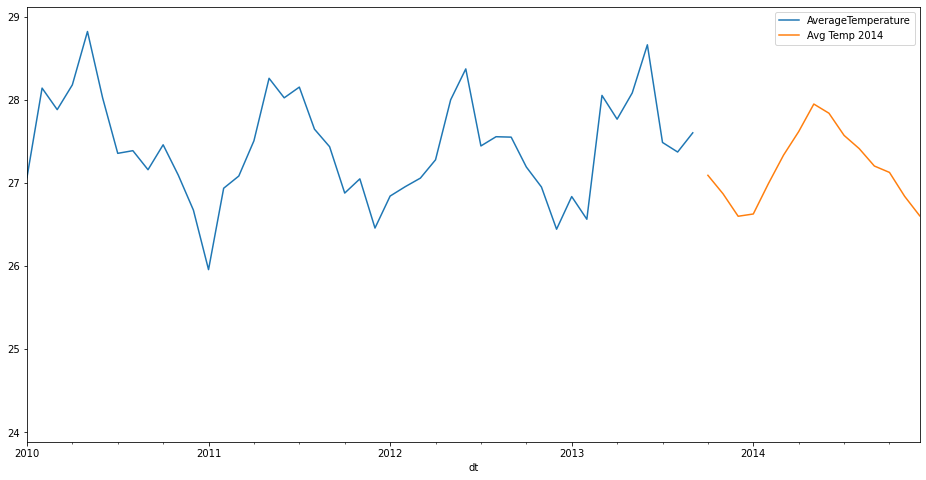

In [ ]:
#View the existing data and the "forecast"in a plot
axis = df.plot()
df_fc.plot(ax=axis, figsize=(16,8))
plt.xlim('2010-01-01','2014-12-01')


In [ ]:
#Get the average forecasted temperature of 2014
Forecasted_2014_AnnualAvg = df_fc['2014-01-01':'2014-12-01'].mean()[0].round(5)
Forecasted_2014_AnnualAvg

27.2597

In [ ]:
#This is the actual average temperature for 2014 retrieved from https://www.weather.gov.sg/climate-past-climate-trends/
Actual_2014_AnnualAvg = 27.9

In [ ]:
#Check percentage error of the "forecast"
percentage_error = 100*(Forecasted_2014_AnnualAvg-Actual_2014_AnnualAvg)/Actual_2014_AnnualAvg
percentage_error.round(2)

-2.29

#Results

* Validation Set RMSE = 0.466

* Forecasted Avg Temperature for 2014 (vs Actual) = 27.26 degrees (vs 27.9 degrees)

* Percentage Error of Forecast = 2.29%

#Analysis

* Model training was iterated with generator batch sizes between 12 to 48 points, LSTM node counts between 100 to 200, hyperbolic tangent and relu activation function and early stopping patience of between 5 to 20.
* Performance was found to be good with a generator batch size of 24 (2 years), 150 nodes using relu activation and an early stopping patience of 10.
* With reference to the model with validation set, an epoch of 16 was found to be sufficient and hence used for the final "forecast" model.
* Trained model produced good results with 0.466 root mean square error when validated with the test set.  
* Final model was trained using full dataset with parameters selected from the previous trained model.
* Final model accurately predicted average annual temperature of 2014, without prior knowledge of the data.
* The prediction fell within 2.29% of the actual data.